Train X_numerical: (1366, 1782, 12), y_train: (1366, 1782)
Train X_categorical_inputs shapes: [(1366, 1782), (1366, 1782), (1366, 1782), (1366, 1782), (1366, 1782), (1366, 1782), (1366, 1782), (1366, 1782), (1366, 1782)]
Val X_numerical: (91, 1782, 12), y_val: (91, 1782)
Val X_categorical_inputs shapes: [(91, 1782), (91, 1782), (91, 1782), (91, 1782), (91, 1782), (91, 1782), (91, 1782), (91, 1782), (91, 1782)]
Test X_numerical: (227, 1782, 12), y_test: (227, 1782)
Test X_categorical_inputs shapes: [(227, 1782), (227, 1782), (227, 1782), (227, 1782), (227, 1782), (227, 1782), (227, 1782), (227, 1782), (227, 1782)]
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 time_series_input (InputLa  [(None, 1782, 12)]           0         []                            
 yer)                                                            

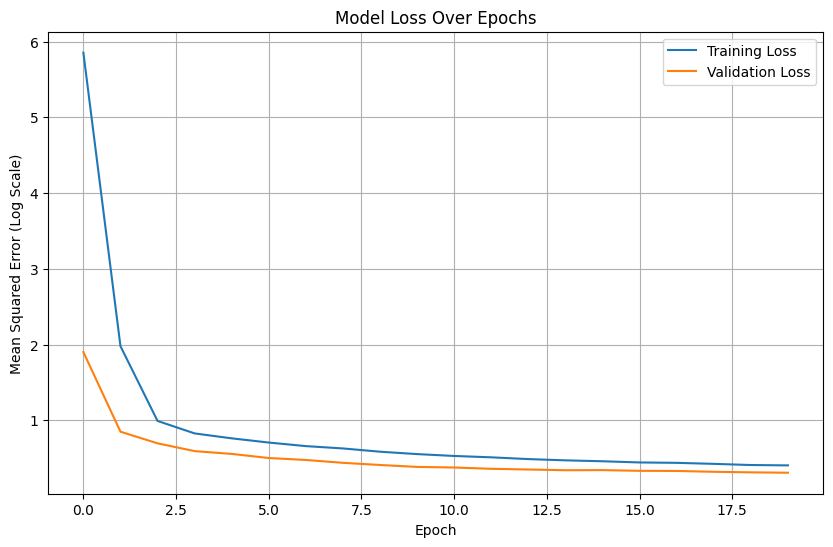

8/8 [==============================] - 1s 125ms/step

LSTM Model Evaluation (on log-transformed scale):
MSE: 0.3343
RMSE: 0.5782
R2 Score: -0.1625

LSTM Model Evaluation (on original sales scale):
MSE: 192165.28
RMSE: 438.37
R2 Score: 0.90


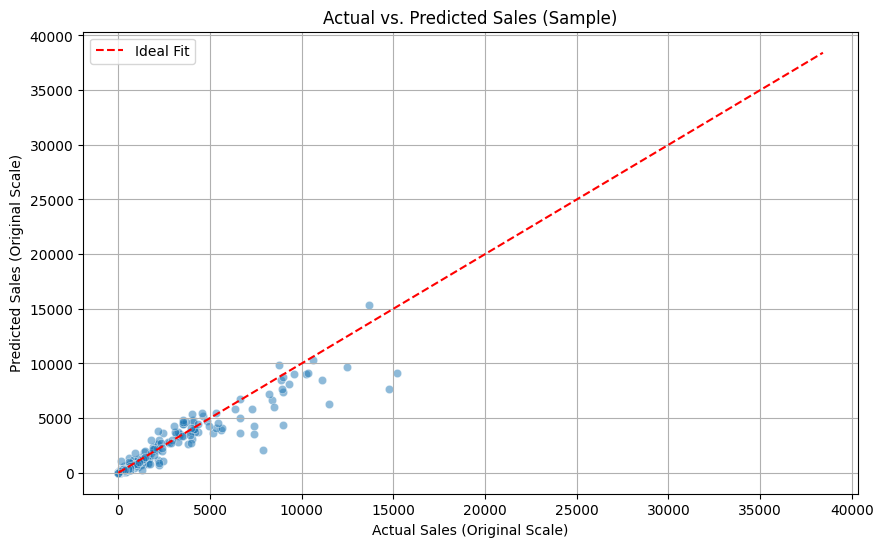

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Flatten, Input, Concatenate, Bidirectional # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.3f}'.format)

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('../data/cleaned_data.csv', parse_dates=['date'])


df['sales'] = np.log1p(df['sales'])
# df['sales'].describe() # You can uncomment this to check

# --- MODIFIED FEATURE DEFINITIONS ---
# 1. Define features for embedding
cat_features_for_embedding = [
    'store_nbr', 'family', 'holiday_type', 'locale', 'city', 'state',
    'store_type', 'promotion_status', 'day_of_week' # Added day_of_week
]

# 2. Define features for LSTM numerical stream
numerical_features_for_lstm = [
    'onpromotion', 'transactions', 'dcoilwtico',
    'sales_lag_7', 'rolling_mean_7', 'is_holiday', 'is_weekend',
    'promo_last_7_days', 'days_to_holiday', 'year', 'month', 'week'
]

target_col = 'sales'

# --- PREPROCESSING ---
# Map day_of_week first as it's specific
day_of_week_mapping = {
    'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3,
    'Friday': 4, 'Saturday': 5, 'Sunday': 6
}
df['day_of_week'] = df['day_of_week'].map(day_of_week_mapping).astype(int)


# Label encode all designated categorical features
label_encoders = {}
for col in cat_features_for_embedding:
    if col != 'day_of_week': # day_of_week is already mapped
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str)) # Ensure string type for LE
        label_encoders[col] = le

# Scale numerical features for LSTM
scaler = RobustScaler()
df[numerical_features_for_lstm] = scaler.fit_transform(df[numerical_features_for_lstm])

# Sort data
df.sort_values(by=['date', 'store_nbr', 'family'], inplace=True)

# Define splits by date
df_train = df[df['date'] < '2016-10-01'].copy() # Use .copy() to avoid SettingWithCopyWarning
df_val = df[(df['date'] >= '2016-10-01') & (df['date'] < '2017-01-01')].copy()
df_test = df[df['date'] >= '2017-01-01'].copy()


# --- PREPARE DATA FOR MODEL ---
n_rows_per_day = 1782 # As specified in your script. Ensure data aligns with this.
# If using mocked data, this might not be 1782, leading to reshape errors.
# This value must be the number of unique (store, family) combinations per day.
# For the mock data: n_stores * len(families) must be 1782. (54 * 33 = 1782)

# Check if n_rows_per_day is consistent
if not df_train.empty:
    actual_rows_train_first_day = df_train[df_train['date'] == df_train['date'].min()].shape[0]
    if actual_rows_train_first_day != n_rows_per_day and df_train['date'].nunique() > 0 :
        print(f"Warning: Expected n_rows_per_day={n_rows_per_day}, but found {actual_rows_train_first_day} for the first day in train set.")
        # You might need to adjust n_rows_per_day or investigate data if this warning appears with real data.


n_train_days = df_train['date'].nunique()
n_val_days = df_val['date'].nunique()
n_test_days = df_test['date'].nunique()

# Prepare numerical data for LSTM
X_train_numerical = df_train[numerical_features_for_lstm].to_numpy().astype(np.float32)
X_val_numerical = df_val[numerical_features_for_lstm].to_numpy().astype(np.float32)
X_test_numerical = df_test[numerical_features_for_lstm].to_numpy().astype(np.float32)

# Reshape numerical data: (days, n_rows_per_day, n_numerical_features_for_lstm)
if n_train_days > 0:
    X_train_numerical = X_train_numerical.reshape((n_train_days, n_rows_per_day, X_train_numerical.shape[1]))
if n_val_days > 0:
    X_val_numerical = X_val_numerical.reshape((n_val_days, n_rows_per_day, X_val_numerical.shape[1]))
if n_test_days > 0:
    X_test_numerical = X_test_numerical.reshape((n_test_days, n_rows_per_day, X_test_numerical.shape[1]))

# Prepare categorical data for Embedding layers
X_train_categorical_inputs = []
X_val_categorical_inputs = []
X_test_categorical_inputs = []

for col in cat_features_for_embedding:
    if n_train_days > 0:
        X_train_categorical_inputs.append(df_train[col].to_numpy().astype(np.int32).reshape(n_train_days, n_rows_per_day))
    if n_val_days > 0:
        X_val_categorical_inputs.append(df_val[col].to_numpy().astype(np.int32).reshape(n_val_days, n_rows_per_day))
    if n_test_days > 0:
        X_test_categorical_inputs.append(df_test[col].to_numpy().astype(np.int32).reshape(n_test_days, n_rows_per_day))

# Prepare target variable
y_train = df_train[target_col].to_numpy().astype(np.float32)
y_val = df_val[target_col].to_numpy().astype(np.float32)
y_test = df_test[target_col].to_numpy().astype(np.float32)

if n_train_days > 0:
    y_train = y_train.reshape(n_train_days, n_rows_per_day)
if n_val_days > 0:
    y_val = y_val.reshape(n_val_days, n_rows_per_day)
if n_test_days > 0:
    y_test = y_test.reshape(n_test_days, n_rows_per_day)


print(f"Train X_numerical: {X_train_numerical.shape if n_train_days > 0 else 'N/A'}, y_train: {y_train.shape if n_train_days > 0 else 'N/A'}")
if X_train_categorical_inputs:
    print(f"Train X_categorical_inputs shapes: {[item.shape for item in X_train_categorical_inputs]}")

print(f"Val X_numerical: {X_val_numerical.shape if n_val_days > 0 else 'N/A'}, y_val: {y_val.shape if n_val_days > 0 else 'N/A'}")
if X_val_categorical_inputs:
    print(f"Val X_categorical_inputs shapes: {[item.shape for item in X_val_categorical_inputs]}")

print(f"Test X_numerical: {X_test_numerical.shape if n_test_days > 0 else 'N/A'}, y_test: {y_test.shape if n_test_days > 0 else 'N/A'}")
if X_test_categorical_inputs:
    print(f"Test X_categorical_inputs shapes: {[item.shape for item in X_test_categorical_inputs]}")


# --- MODEL DEFINITION ---
embedding_dim = 10 # You can tune this
vocab_sizes = {col: df[col].nunique() for col in cat_features_for_embedding}

# Input layer for the numerical time series data
time_series_input = Input(shape=(n_rows_per_day, len(numerical_features_for_lstm)), name="time_series_input")
lstm_layer = Bidirectional(LSTM(64, return_sequences=True))(time_series_input) # return_sequences=True is important

# Input layers and Embedding layers for categorical features
categorical_input_layers = []
embedding_layers = []

for col in cat_features_for_embedding:
    vocab_size = vocab_sizes[col]
    input_layer = Input(shape=(n_rows_per_day,), name=f"{col}_input") # Each categorical feature is a sequence
    categorical_input_layers.append(input_layer)
    
    # Embedding layer
    # Add 1 to vocab_size if your label encoding is 0 to N-1, to account for all values.
    # Keras Embedding layer expects input indices from 0 to vocab_size-1.
    # If nunique() gives N, and LE gives 0..N-1, then vocab_size=N is correct for input_dim.
    embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, name=f"{col}_embedding")(input_layer)
    embedding_layers.append(embedding)

# Concatenate LSTM output with all embedding outputs
merged = Concatenate()([lstm_layer] + embedding_layers)

# Dense layers
dense_layer = Dense(128, activation='relu')(merged)
dense_layer = Dropout(0.2)(dense_layer)
output_layer = Dense(1, activation='linear')(dense_layer) # Output for each of the 1782 items

# Flatten the output to match y_train's shape (None, 1782)
output_final = Flatten(name='output_flatten')(output_layer)

# Define the model
model = Model(inputs=categorical_input_layers + [time_series_input], outputs=output_final)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Print model summary
model.summary()


# --- MODEL TRAINING ---
if n_train_days > 0 and n_val_days > 0:
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    history = model.fit(
        X_train_categorical_inputs + [X_train_numerical], # Order must match model definition
        y_train,
        epochs=20, # Consider increasing epochs if needed, with early stopping
        batch_size=32, # Original was 64, 32 might also work or be better
        validation_data=(X_val_categorical_inputs + [X_val_numerical], y_val),
        callbacks=[early_stop]
    )

    # Plot training history
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error (Log Scale)')
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("Skipping training due to empty training or validation set (check date splits and data).")


# --- MODEL EVALUATION ---
if n_test_days > 0 and (n_train_days > 0 and n_val_days > 0): # Ensure model was trained
    y_pred_log_scale = model.predict(X_test_categorical_inputs + [X_test_numerical])

    # y_test is already on the log scale
    # y_pred_log_scale contains predictions on the log scale

    mse_log = mean_squared_error(y_test, y_pred_log_scale)
    rmse_log = np.sqrt(mse_log)
    r2_log = r2_score(y_test, y_pred_log_scale)

    print(f'\nLSTM Model Evaluation (on log-transformed scale):')
    print(f'MSE: {mse_log:.4f}')
    print(f'RMSE: {rmse_log:.4f}')
    print(f'R2 Score: {r2_log:.4f}')

    # If you want to evaluate on the original scale:
    # Ensure y_test was not reshaped if you load original df_test['sales']
    # For this, you'd need y_test_original = np.expm1(y_test.flatten())
    # and y_pred_original = np.expm1(y_pred_log_scale.flatten())
    
    # Reshape y_test and y_pred_log_scale back to 1D arrays for inverse transform
    y_test_flat = y_test.flatten()
    y_pred_flat = y_pred_log_scale.flatten()

    # Inverse transform
    y_test_original_scale = np.expm1(y_test_flat)
    y_pred_original_scale = np.expm1(y_pred_flat)
    
    # Filter out potential NaNs or Infs from expm1 if sales were 0 (log1p(0)=0, expm1(0)=0)
    # or if predictions are extremely low leading to issues with expm1.
    valid_indices = np.isfinite(y_test_original_scale) & np.isfinite(y_pred_original_scale)
    y_test_original_scale = y_test_original_scale[valid_indices]
    y_pred_original_scale = y_pred_original_scale[valid_indices]


    if len(y_test_original_scale) > 0:
        mse_original = mean_squared_error(y_test_original_scale, y_pred_original_scale)
        rmse_original = np.sqrt(mse_original)
        r2_original = r2_score(y_test_original_scale, y_pred_original_scale)

        print(f'\nLSTM Model Evaluation (on original sales scale):')
        print(f'MSE: {mse_original:.2f}')
        print(f'RMSE: {rmse_original:.2f}')
        print(f'R2 Score: {r2_original:.2f}')
        
        # Scatter plot of actual vs. predicted on original scale (sample)
        plt.figure(figsize=(10, 6))
        sample_size = min(1000, len(y_test_original_scale)) # Plot a sample
        indices = np.random.choice(len(y_test_original_scale), sample_size, replace=False)
        sns.scatterplot(x=y_test_original_scale[indices], y=y_pred_original_scale[indices], alpha=0.5)
        plt.plot([min(y_test_original_scale), max(y_test_original_scale)], [min(y_test_original_scale), max(y_test_original_scale)], '--', color='red', label='Ideal Fit')
        plt.xlabel('Actual Sales (Original Scale)')
        plt.ylabel('Predicted Sales (Original Scale)')
        plt.title('Actual vs. Predicted Sales (Sample)')
        plt.legend()
        plt.grid(True)
        plt.show()

    else:
        print("Could not evaluate on original scale due to no valid (finite) values after inverse transformation.")
elif not (n_train_days > 0 and n_val_days > 0):
     print("Skipping evaluation because the model was not trained.")
else:
    print("Skipping evaluation due to empty test set.")



In [ ]:
import mlflow.tensorflow
import mlflow.tensorflow
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Flatten, Input, Concatenate, Bidirectional # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
import matplotlib.pyplot as plt
import seaborn as sns
import os # For creating artifact directories

# --- MLflow Imports ---
import mlflow
import mlflow.tensorflow # Ensure this is imported if not already
mlflow_callback = mlflow.tensorflow.MlflowCallback(log_every_epoch=True)

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.3f}'.format)

import warnings
warnings.filterwarnings("ignore")

# --- MLflow Setup ---
# Define an experiment name. MLflow will create it if it doesn't exist.
EXPERIMENT_NAME = "Sales_Forecasting_LSTM_v2" # Choose a descriptive name
mlflow.set_experiment(EXPERIMENT_NAME)

# --- Start an MLflow Run ---
# It's good practice to wrap your training and evaluation in a run context
with mlflow.start_run(run_name="LSTM_with_Embeddings_and_Numerical"): # Optional: give your run a name
    # Log script name or a tag for context (optional)
    mlflow.set_tag("mlflow.source.name", "lstm_sales_forecasting_script.py")

    # Assume df is loaded as in your script
    df = pd.read_csv('../data/cleaned_data.csv', parse_dates=['date'])
    

    df['sales'] = np.log1p(df['sales'])

    # --- MODIFIED FEATURE DEFINITIONS ---
    cat_features_for_embedding = [
        'store_nbr', 'family', 'holiday_type', 'locale', 'city', 'state',
        'store_type', 'promotion_status', 'day_of_week'
    ]
    numerical_features_for_lstm = [
        'onpromotion', 'transactions', 'dcoilwtico',
        'sales_lag_7', 'rolling_mean_7', 'is_holiday', 'is_weekend',
        'promo_last_7_days', 'days_to_holiday', 'year', 'month', 'week'
    ]
    target_col = 'sales'

    # --- Log Parameters to MLflow ---
    mlflow.log_param("target_column", target_col)
    mlflow.log_param("categorical_features_embedding_count", len(cat_features_for_embedding))
    mlflow.log_param("numerical_features_lstm_count", len(numerical_features_for_lstm))
    # Log the lists themselves as artifacts if they are long, or as params if short enough (MLflow param values have length limits)
    # For simplicity here, let's log counts. You can save the full lists to a file and log as artifact.
    # Example:
    # with open("cat_features.txt", "w") as f: for item in cat_features_for_embedding: f.write("%s\n" % item)
    # mlflow.log_artifact("cat_features.txt", artifact_path="feature_lists")


    # --- PREPROCESSING ---
    day_of_week_mapping = {
        'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3,
        'Friday': 4, 'Saturday': 5, 'Sunday': 6
    }
    df['day_of_week'] = df['day_of_week'].map(day_of_week_mapping).astype(int)

    label_encoders = {}
    for col in cat_features_for_embedding:
        if col != 'day_of_week':
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            label_encoders[col] = le
            # Optionally save label encoders and log them as artifacts if needed for inference later
            # import joblib
            # encoder_path = f"label_encoder_{col}.joblib"
            # joblib.dump(le, encoder_path)
            # mlflow.log_artifact(encoder_path, artifact_path="label_encoders")


    scaler = RobustScaler()
    df[numerical_features_for_lstm] = scaler.fit_transform(df[numerical_features_for_lstm])
    # Optionally save the scaler and log as artifact
    # import joblib
    # scaler_path = "robust_scaler_numerical.joblib"
    # joblib.dump(scaler, scaler_path)
    # mlflow.log_artifact(scaler_path, artifact_path="scalers")


    df.sort_values(by=['date', 'store_nbr', 'family'], inplace=True)

    train_split_date = '2016-10-01'
    val_split_date_start = '2016-10-01'
    val_split_date_end = '2017-01-01'
    test_split_date_start = '2017-01-01'

    mlflow.log_param("train_split_date", train_split_date)
    mlflow.log_param("val_split_date_start", val_split_date_start)
    mlflow.log_param("val_split_date_end", val_split_date_end)
    mlflow.log_param("test_split_date_start", test_split_date_start)

    df_train = df[df['date'] < train_split_date].copy()
    df_val = df[(df['date'] >= val_split_date_start) & (df['date'] < val_split_date_end)].copy()
    df_test = df[df['date'] >= test_split_date_start].copy()

    n_rows_per_day = 1782
    if not df_train.empty:
        actual_rows_train_first_day = df_train[df_train['date'] == df_train['date'].min()].shape[0]
        if actual_rows_train_first_day != n_rows_per_day and df_train['date'].nunique() > 0 :
            print(f"Warning: Expected n_rows_per_day={n_rows_per_day}, but found {actual_rows_train_first_day} for the first day in train set.")
    mlflow.log_param("n_rows_per_day", n_rows_per_day)


    n_train_days = df_train['date'].nunique()
    n_val_days = df_val['date'].nunique()
    n_test_days = df_test['date'].nunique()

    X_train_numerical = df_train[numerical_features_for_lstm].to_numpy().astype(np.float32)
    X_val_numerical = df_val[numerical_features_for_lstm].to_numpy().astype(np.float32)
    X_test_numerical = df_test[numerical_features_for_lstm].to_numpy().astype(np.float32)

    if n_train_days > 0: X_train_numerical = X_train_numerical.reshape((n_train_days, n_rows_per_day, X_train_numerical.shape[1]))
    if n_val_days > 0: X_val_numerical = X_val_numerical.reshape((n_val_days, n_rows_per_day, X_val_numerical.shape[1]))
    if n_test_days > 0: X_test_numerical = X_test_numerical.reshape((n_test_days, n_rows_per_day, X_test_numerical.shape[1]))

    X_train_categorical_inputs, X_val_categorical_inputs, X_test_categorical_inputs = [], [], []
    for col in cat_features_for_embedding:
        if n_train_days > 0: X_train_categorical_inputs.append(df_train[col].to_numpy().astype(np.int32).reshape(n_train_days, n_rows_per_day))
        if n_val_days > 0: X_val_categorical_inputs.append(df_val[col].to_numpy().astype(np.int32).reshape(n_val_days, n_rows_per_day))
        if n_test_days > 0: X_test_categorical_inputs.append(df_test[col].to_numpy().astype(np.int32).reshape(n_test_days, n_rows_per_day))

    y_train = df_train[target_col].to_numpy().astype(np.float32)
    y_val = df_val[target_col].to_numpy().astype(np.float32)
    y_test = df_test[target_col].to_numpy().astype(np.float32)

    if n_train_days > 0: y_train = y_train.reshape(n_train_days, n_rows_per_day)
    if n_val_days > 0: y_val = y_val.reshape(n_val_days, n_rows_per_day)
    if n_test_days > 0: y_test = y_test.reshape(n_test_days, n_rows_per_day)

    # --- MODEL DEFINITION ---
    embedding_dim = 10
    lstm_units = 64
    dense_units = 128
    dropout_rate = 0.2
    optimizer_name = 'adam'
    loss_function = 'mse'

    # --- Log Model Hyperparameters ---
    mlflow.log_param("embedding_dim", embedding_dim)
    mlflow.log_param("lstm_units", lstm_units)
    mlflow.log_param("dense_units", dense_units)
    mlflow.log_param("dropout_rate", dropout_rate)
    mlflow.log_param("optimizer", optimizer_name)
    mlflow.log_param("loss_function", loss_function)

    vocab_sizes = {col: df[col].nunique() for col in cat_features_for_embedding}

    time_series_input = Input(shape=(n_rows_per_day, len(numerical_features_for_lstm)), name="time_series_input")
    lstm_layer = Bidirectional(LSTM(64, return_sequences=True))(time_series_input)

    categorical_input_layers, embedding_layers = [], []
    for col in cat_features_for_embedding:
        vocab_size = vocab_sizes[col]
        input_layer = Input(shape=(n_rows_per_day,), name=f"{col}_input")
        categorical_input_layers.append(input_layer)
        embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, name=f"{col}_embedding")(input_layer)
        embedding_layers.append(embedding)

    merged = Concatenate()([lstm_layer] + embedding_layers)
    dense_layer = Dense(dense_units, activation='relu')(merged)
    dense_layer = Dropout(dropout_rate)(dense_layer)
    output_layer = Dense(1, activation='linear')(dense_layer)
    output_final = Flatten(name='output_flatten')(output_layer)

    model = Model(inputs=categorical_input_layers + [time_series_input], outputs=output_final)
    model.compile(optimizer=optimizer_name, loss=loss_function)
    # model.summary() # Can be logged as an artifact

    # Log model summary as an artifact
    summary_path = "model_summary.txt"
    with open(summary_path, "w") as f:
        model.summary(print_fn=lambda x: f.write(x + '\n'))
    mlflow.log_artifact(summary_path, artifact_path="model_architecture")


    # --- MODEL TRAINING ---
    epochs = 100 # Original was 20
    batch_size = 32 # Original was 64
    early_stopping_patience = 10 # Original was 5

    mlflow.log_param("epochs", epochs)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("early_stopping_patience", early_stopping_patience)

    if n_train_days > 0 and n_val_days > 0:
        early_stop = EarlyStopping(monitor='val_loss', patience=early_stopping_patience, restore_best_weights=True)

        # --- MLflow Keras Callback ---
        # This callback automatically logs metrics like loss and val_loss per epoch,
        # and can also log the model itself.
        mlflow_callback = mlflow.tensorflow.MlflowCallback(log_every_epoch=True) # Can add other options

        print("Starting model training with MLflow logging...")
        history = model.fit(
            X_train_categorical_inputs + [X_train_numerical],
            y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val_categorical_inputs + [X_val_numerical], y_val),
            callbacks=[early_stop, mlflow_callback] # Add MLflow callback here
        )
        print("Model training finished.")

        # --- Log Training History Plot as Artifact ---
        # Create a directory for plots if it doesn't exist
        plot_dir = "plots"
        if not os.path.exists(plot_dir):
            os.makedirs(plot_dir)

        loss_plot_path = os.path.join(plot_dir, "training_validation_loss.png")
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Mean Squared Error (Log Scale)')
        plt.legend()
        plt.grid(True)
        plt.savefig(loss_plot_path) # Save the plot
        plt.close() # Close the plot to free memory
        mlflow.log_artifact(loss_plot_path, artifact_path="training_plots")
        print(f"Logged training loss plot to MLflow: {loss_plot_path}")

        # --- Log Final Training Metrics (optional, as MlflowCallback logs per epoch) ---
        # final_train_loss = history.history['loss'][-1]
        # final_val_loss = history.history['val_loss'][-1]
        # mlflow.log_metric("final_train_loss_manual", final_train_loss)
        # mlflow.log_metric("final_val_loss_manual", final_val_loss)

    else:
        print("Skipping training due to empty training or validation set.")
        mlflow.log_param("training_skipped", True)


    # --- MODEL EVALUATION ---
    if n_test_days > 0 and (n_train_days > 0 and n_val_days > 0): # Ensure model was trained
        print("Starting model evaluation...")
        y_pred_log_scale = model.predict(X_test_categorical_inputs + [X_test_numerical])

        y_test_flat = y_test.flatten()
        y_pred_flat = y_pred_log_scale.flatten()

        y_test_original_scale = np.expm1(y_test_flat)
        y_pred_original_scale = np.expm1(y_pred_flat)

        valid_indices = np.isfinite(y_test_original_scale) & np.isfinite(y_pred_original_scale)
        y_test_original_scale_valid = y_test_original_scale[valid_indices]
        y_pred_original_scale_valid = y_pred_original_scale[valid_indices]

        if len(y_test_original_scale_valid) > 0:
            mse_original = mean_squared_error(y_test_original_scale_valid, y_pred_original_scale_valid)
            rmse_original = np.sqrt(mse_original)
            r2_original = r2_score(y_test_original_scale_valid, y_pred_original_scale_valid)

            print(f'\nLSTM Model Evaluation (on original sales scale):')
            print(f'MSE: {mse_original:.2f}')
            print(f'RMSE: {rmse_original:.2f}')
            print(f'R2 Score: {r2_original:.2f}')

            # --- Log Evaluation Metrics (Original Scale) to MLflow ---
            mlflow.log_metric("test_mse_original_scale", mse_original)
            mlflow.log_metric("test_rmse_original_scale", rmse_original)
            mlflow.log_metric("test_r2_original_scale", r2_original)

            # --- Log Actual vs. Predicted Plot as Artifact ---
            plot_dir = "plots" # ensure it exists
            actual_vs_pred_plot_path = os.path.join(plot_dir, "actual_vs_predicted_original_scale.png")
            plt.figure(figsize=(10, 6))
            sample_size = min(1000, len(y_test_original_scale_valid))
            indices = np.random.choice(len(y_test_original_scale_valid), sample_size, replace=False)
            sns.scatterplot(x=y_test_original_scale_valid[indices], y=y_pred_original_scale_valid[indices], alpha=0.5)
            min_val = min(np.min(y_test_original_scale_valid), np.min(y_pred_original_scale_valid))
            max_val = max(np.max(y_test_original_scale_valid), np.max(y_pred_original_scale_valid))
            plt.plot([min_val, max_val], [min_val, max_val], '--', color='red', label='Ideal Fit')
            plt.xlabel('Actual Sales (Original Scale)')
            plt.ylabel('Predicted Sales (Original Scale)')
            plt.title('Actual vs. Predicted Sales (Sample on Original Scale)')
            plt.legend()
            plt.grid(True)
            plt.savefig(actual_vs_pred_plot_path) # Save the plot
            plt.close() # Close the plot
            mlflow.log_artifact(actual_vs_pred_plot_path, artifact_path="evaluation_plots")
            print(f"Logged actual vs predicted plot to MLflow: {actual_vs_pred_plot_path}")
        else:
            print("Could not evaluate on original scale due to no valid (finite) values.")
            mlflow.log_param("evaluation_original_scale_skipped", True)

        # --- Log Keras Model to MLflow ---
        # This logs the model in MLflow's format, which can include a Conda environment and a signature.
        # You can also log the raw Keras model (e.g., .h5 file) as an artifact if preferred.
        print("Logging Keras model to MLflow...")
        mlflow.tensorflow.log_model(
            model,
            artifact_path="tensorflow_lstm_sales_model" # This will be the directory name in MLflow artifacts
            # registered_model_name="LSTM_Sales_Forecaster" # Optional: Register the model in MLflow Model Registry
        )
        print("Tensorflow model logged to MLflow.")

    elif not (n_train_days > 0 and n_val_days > 0):
        print("Skipping evaluation because the model was not trained.")
        mlflow.log_param("evaluation_skipped_no_training", True)
    else:
        print("Skipping evaluation due to empty test set.")
        mlflow.log_param("evaluation_skipped_empty_test_set", True)

    print(f"MLflow Run completed. Check the MLflow UI. Run ID: {mlflow.active_run().info.run_id}")


Starting model training with MLflow logging...
Epoch 1/100

43/43 [==============================] - 26s 541ms/step - loss: 6.0026 - val_loss: 2.1763
Epoch 2/100
43/43 [==============================] - 22s 510ms/step - loss: 2.1105 - val_loss: 0.8677
Epoch 3/100
43/43 [==============================] - 23s 531ms/step - loss: 1.0310 - val_loss: 0.6916
Epoch 4/100
43/43 [==============================] - 23s 538ms/step - loss: 0.8368 - val_loss: 0.5905
Epoch 5/100
43/43 [==============================] - 23s 534ms/step - loss: 0.7525 - val_loss: 0.5757
Epoch 6/100
43/43 [==============================] - 23s 540ms/step - loss: 0.6922 - val_loss: 0.5007
Epoch 7/100
43/43 [==============================] - 24s 552ms/step - loss: 0.6423 - val_loss: 0.4720
Epoch 8/100
43/43 [==============================] - 24s 547ms/step - loss: 0.6011 - val_loss: 0.4343
Epoch 9/100
43/43 [==============================] - 23s 537ms/step - loss: 0.5686 - val_loss: 0.4130
Epoch 10/100
43/43 [=============

2025/05/10 04:47:03 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


Logged actual vs predicted plot to MLflow: plots\actual_vs_predicted_original_scale.png
Logging Keras model to MLflow...
INFO:tensorflow:Assets written to: C:\Users\seife\AppData\Local\Temp\tmpsp7o1_0g\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\seife\AppData\Local\Temp\tmpsp7o1_0g\model\data\model\assets
2025/05/10 04:47:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Tensorflow model logged to MLflow.
MLflow Run completed. Check the MLflow UI. Run ID: b4d0a4578e384dc08e1cf7a689e398ef
